# A Spatio-Temporal Diffusion Model for Missing and Real-Time Financial Data Inference
Data analysis attempt for preprocessing in [A Spatio-Temporal Diffusion Model for Missing and Real-Time Financial Data Inference, Yupeng Fang, Ruirui Liu, Huichou Huang, Peilin Zhao, Qingyao Wu (2023)](https://dl.acm.org/doi/10.1145/3627673.3679806).

Using the OSAP (Open Source Asset Pricing) dataset, downloaded from [here](https://www.openassetpricing.com/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Loading and Preprocessing Data

*This notebook has been run using Data Release 2024.10/Firm Level Characteristics/Full Sets/signed_predictors_dl_wide.csv*

What we are looking for, is preprocessing the OSAP dataset to obtain a dataset with shape (N, L, K):
- N: number of stocks (permno values in the dataset)
- L: number of periods (yyyymm)
- K = 129, number of features (as stated in the paper, columns in the dataset)

Preprocessing steps:
- (Not in the paper) Remove characteristics that have more that $\frac{2}{3}$ missing values, this is the way we found to reduce the number of features to 129 (excluding permno and yyyymm), 0.66 and 0.67 doesn't allow to obtain 129.
- Filter stocks with history window of **at least L = 60 months (incl.)**, *to obtain sufficient information for learning the temporal dependency*
- Clip characteristics that deviate from the mean by more than 5 $\sigma$, *To reduce the effect of outliers
and train an effective and robust diffusion mode*
- Standardize each characteristic
- Split the data into train, validation and test sets (1970-1995, 1995-2005, 2005-2019)



What we should end up with after preprocessing and splitting the data is:

| subset | range | periods | stocks |
|--------|-------|---------|--------|
| Train  | 1970-1995 | 312 | 1015 |
| Valid  | 1995-2005 | 120 | 787 |
| Test   | 2005-2019 | 168 | 856 |

In [3]:
df = pd.read_csv('Data Release 2024.10/Firm Level Characteristics/Full Sets/signed_predictors_dl_wide.csv')
df.head()

,permno,yyyymm,AM,AOP,AbnormalAccruals,Accruals,AccrualsBM,Activism1,Activism2,AdExp,...,retConglomerate,roaq,sfe,sinAlgo,skew1,std_turn,tang,zerotrade12M,zerotrade1M,zerotrade6M
0,10000,198601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000,198602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.785175e-08,NaN
2,10000,198603,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.023392e-07,NaN
3,10000,198604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.467463e-08,NaN
4,10000,198605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.649551e-08,NaN


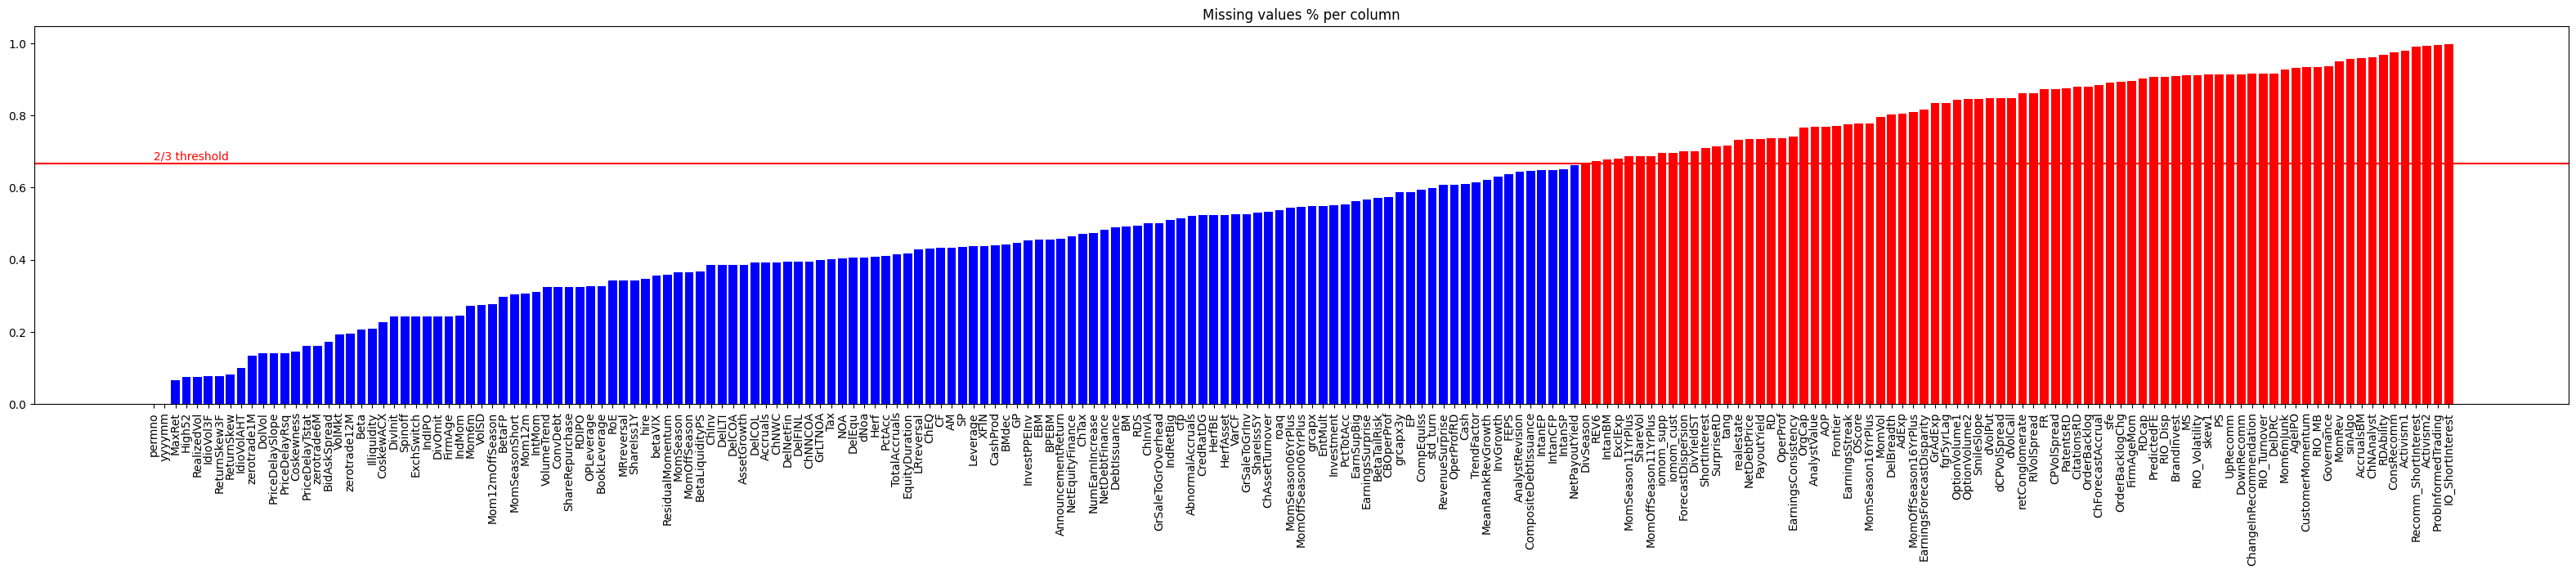

In [4]:
missing = df.isna().mean().sort_values()
plt.figure(figsize=(40, 6))
plt.bar(missing.index, missing.values, color=np.where(missing > 2/3, 'red', 'blue'))
plt.xticks(rotation=90)
plt.title('Missing values % per column')
plt.axhline(2/3, color='red')
plt.text(0, 2/3 + 0.01, '2/3 threshold', color='red')
plt.show()

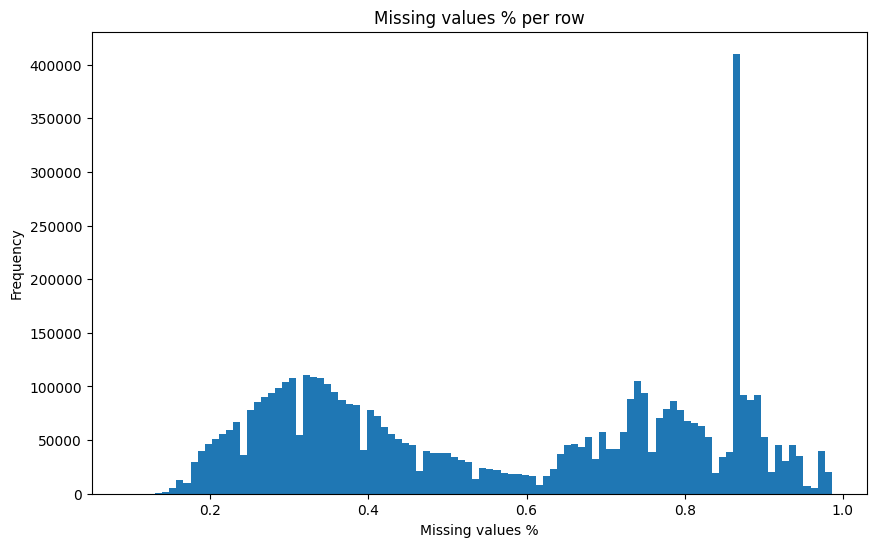

In [5]:
# percentage of na values per row
missing_row = df.isna().mean(axis=1)
plt.figure(figsize=(10, 6))
plt.hist(missing_row, bins=100)
plt.title('Missing values % per row')
plt.xlabel('Missing values %')
plt.ylabel('Frequency')
plt.show()

In [7]:
from stdm.utils.data.preprocessing import remove_nan_columns, remove_not_enough_months, remove_outliers, standard_scale, remove_nan_rows

In [8]:
remove_nan_columns(df, threshold=2/3, inplace=True)
df.shape

(5273600, 131)

In [8]:
# remove_nan_columns(df, threshold=2/3, inplace=True)
# train = df[df['yyyymm'] <= 199512].copy()
# val = df[(df['yyyymm'] > 199512) & (df['yyyymm'] <= 200512)].copy()
# test = df[(df['yyyymm'] >= 200512) & (df['yyyymm'] < 201912)].copy()
# print(len(train['permno'].unique()), len(val['permno'].unique()), len(test['permno'].unique()))

In [10]:
remove_not_enough_months(df, L=60, inplace=True)
# remove_not_enough_months(train, L=60, inplace=True)
# remove_not_enough_months(val, L=60, inplace=True)
# remove_not_enough_months(test, L=60, inplace=True)
# print(train.shape, val.shape, test.shape)
# print(len(train['permno'].unique()), len(val['permno'].unique()), len(test['permno'].unique()))

In [11]:
remove_outliers(df, n_std=5, exclude_columns=['permno', 'yyyymm'], inplace=True)

# remove_outliers(train, n_std=5, exclude_columns=['permno', 'yyyymm'], inplace=True)
# remove_outliers(val, n_std=5, exclude_columns=['permno', 'yyyymm'], inplace=True)
# remove_outliers(test, n_std=5, exclude_columns=['permno', 'yyyymm'], inplace=True)
# print(train.shape, val.shape, test.shape)
# print(len(train['permno'].unique()), len(val['permno'].unique()), len(test['permno'].unique()))

In [12]:
scaler, _ = standard_scale(df, exclude_columns=['permno', 'yyyymm'], inplace=True)

# scaler, _ = standard_scale(train, exclude_columns=['permno', 'yyyymm'], inplace=True)
# column_to_scale = [col for col in train.columns if col not in ['permno', 'yyyymm']]
# scaler.transform(val[column_to_scale])
# scaler.transform(test[column_to_scale])
# train.head()

In [9]:
row_threshold = 1/131
remove_nan_rows(df, threshold=row_threshold, inplace=True)

# remove_nan_rows(train, threshold=row_threshold, inplace=True)
# remove_nan_rows(val, threshold=row_threshold, inplace=True)
# remove_nan_rows(test, threshold=row_threshold, inplace=True)

# print(train.shape, val.shape, test.shape)
# print(len(train['permno'].unique()), len(val['permno'].unique()), len(test['permno'].unique()))

In [13]:
train = df[df['yyyymm'] <= 199512].copy()
val = df[(df['yyyymm'] > 199512) & (df['yyyymm'] <= 200512)].copy()
test = df[(df['yyyymm'] >= 200512) & (df['yyyymm'] < 201912)].copy()
print(len(train['permno'].unique()), len(val['permno'].unique()), len(test['permno'].unique()))

14416 11793 11858
